## Tutorial 10, Question 1a

In [1]:
import os
import pylab
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Create figures directory if it doesn't exist
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

creating the figures folder


In [2]:
# Define input patterns
X = torch.tensor([[[1, 1, 1],[0, 0, 0], [0, 0, 0]],
                  [[1, 0, 0],[1, 0, 0], [1, 0, 0]],
                  [[0, 0, 1],[0, 1, 0], [1, 0, 0]],
                  [[1, 0, 0],[0, 1, 0], [0, 0, 1]],
                  [[1, 0, 0], [1, 0, 0], [1, 1, 1]]], dtype=torch.float32)
X = X.reshape(5, 9)
print(X)

# Set the random seed for reproducibility
seed = 20
torch.manual_seed(seed)

tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0., 1., 1., 1.]])


# Defining an Autoencoder

In this section, we define a simple autoencoder. An autoencoder is a type of artificial neural network used to learn efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction.

## Class Definition: `Autoencoder`

The `Autoencoder` class inherits from `nn.Module` and customizes the building blocks of its neural network.

### Initialization Method: `__init__`

- **Parameters**:
    - `n_input` (int): The number of input neurons (dimension of the input data).
    - `n_hidden` (int): The number of neurons in the hidden layer. This parameter dictates the encoding dimension.

- **Attributes**:
    - `self.W` (Tensor): Weights for the input to hidden layer transformation, initialized with a standard normal distribution scaled by `1/sqrt(n_input)` for stability.
    - `self.b` (Tensor): Biases for the hidden layer, initialized as zeros.
    - `self.b_prime` (Tensor): Biases for the reconstruction layer, initialized as zeros.

### Forward Method: `forward`

- **Parameters**:
    - `x` (Tensor): The input data to the autoencoder.

- **Operations**:
    1. **Encoding**: Computes the hidden layer activations `h` using a sigmoid activation function. This represents the encoded input data.
    2. **Decoding**: Computes the reconstruction `y` from the hidden representation `h` using the transposed weights `self.W.t()` and adding the bias `self.b_prime`. The sigmoid activation function is applied to the output.
    3. **Binarization**: Produces a binary output `o` by applying a threshold of 0.5 to the reconstructed output `y`.

- **Returns**:
    - `y` (Tensor): The reconstructed data (decoded output).
    - `o` (Tensor): The binarized version of the reconstructed data.

## Creating an Instance of the Autoencoder

An instance of the `Autoencoder` class is created with `n_input=5` and `n_hidden=3`, specifying the dimensions of the input and the hidden layer, respectively.

```python
autoencoder = Autoencoder(n_input=9, n_hidden=4)


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(n_input, n_hidden) * np.sqrt(1. / n_input))
        self.W_prime = nn.Parameter(torch.randn(n_hidden, n_input) * np.sqrt(1. / n_input))
        self.b = nn.Parameter(torch.zeros(n_hidden))
        self.b_prime = nn.Parameter(torch.zeros(n_input))

    def forward(self, x):
        h = torch.sigmoid(torch.matmul(x, self.W) + self.b)
        y = torch.sigmoid(torch.matmul(h, self.W_prime) + self.b_prime)
        o = torch.where(y > 0.5, torch.ones_like(y), torch.zeros_like(y))
        return h, y, o

autoencoder = Autoencoder(n_input=9, n_hidden=4)

# Understanding the Training Code

In this section, we'll explain the PyTorch code used for training an autoencoder. We define the optimizer, the custom loss function, and the training function.

## Optimizer

The first part of the code defines the optimizer that we'll use for training:

```python
optimizer = optim.SGD(autoencoder.parameters(), lr=0.1)
```


## Loss Function for Binary Cross-Entropy and Bit Error

The code snippet defines a loss function that calculates two types of losses for a binary classification problem: the binary cross-entropy loss and the bit error loss.

### Binary Cross-Entropy Loss (`entropy_loss`):

- This loss measures the performance of a classification model whose output is a probability value between 0 and 1.
- The loss increases as the predicted probability diverges from the actual label.
- It is calculated using the formula: `-torch.mean(torch.sum(original * torch.log(y) + (1. - original) * torch.log(1. - y), dim=1))`
  - `original` is the true label (ground truth), and `y` is the predicted probability by the model.
  - The logarithmic function is applied to each predicted probability `y` and `1 - y`, which is then multiplied by the actual label `original` and `1 - original`, respectively.
  - The sum of these values is computed for each sample in the batch (`dim=1` indicates summation over the feature dimension).
  - The mean of these sums is taken across the batch to get the average loss.

### Bit Error Loss (`bit_loss`):

- This loss counts the number of bits that are different between the predicted output `o` and the actual label `original`.
- It is a simple count of how many predictions are exactly wrong, without considering the probability of the prediction.
- Calculated using `torch.sum(o != original).item()`, which computes the element-wise inequality between `o` and `original`, sums up all the `True` values (indicating a bit error), and converts the result to a Python scalar with `.item()`.

### Return Values:

- The function returns both `entropy_loss` and `bit_loss`.
- `entropy_loss` is the primary loss used for training the model, while `bit_loss` can be used as an additional metric to understand the model's performance in terms of exact bit matches.



In [4]:
# Define optimizer
optimizer = optim.SGD(autoencoder.parameters(), lr=0.1)

# Loss function
def loss(y, o, original):
    entropy_loss = -torch.mean(torch.sum(original * torch.log(y) + (1. - original) * torch.log(1. - y), dim=1))
    bit_loss = torch.sum(o != original).item()
    return entropy_loss, bit_loss

In [5]:
# Training function
def train(original):
    optimizer.zero_grad()  # Zero gradients
    h, y, o = autoencoder(original)  # Forward pass
    entropy_loss, bit_loss = loss(y, o, original)
    entropy_loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return entropy_loss.item(), bit_loss

In [6]:
# Training the model
epochs = 2000
l, bl = [], []
for i in range(epochs):
    l_, bl_ = train(X)
    l.append(l_)
    bl.append(bl_)
    if i % 100 == 0:
        print(f'epoch: {i}, entropy_loss: {l[i]}, bit_loss: {bl[i]}')

epoch: 0, entropy_loss: 6.289218902587891, bit_loss: 20
epoch: 100, entropy_loss: 4.199206829071045, bit_loss: 8
epoch: 200, entropy_loss: 3.2703049182891846, bit_loss: 9
epoch: 300, entropy_loss: 2.8272175788879395, bit_loss: 9
epoch: 400, entropy_loss: 2.4889252185821533, bit_loss: 7
epoch: 500, entropy_loss: 2.1210803985595703, bit_loss: 5
epoch: 600, entropy_loss: 1.7097148895263672, bit_loss: 0
epoch: 700, entropy_loss: 1.3485161066055298, bit_loss: 0
epoch: 800, entropy_loss: 1.0901447534561157, bit_loss: 0
epoch: 900, entropy_loss: 0.9078000783920288, bit_loss: 0
epoch: 1000, entropy_loss: 0.7744521498680115, bit_loss: 0
epoch: 1100, entropy_loss: 0.6734216809272766, bit_loss: 0
epoch: 1200, entropy_loss: 0.5945383310317993, bit_loss: 0
epoch: 1300, entropy_loss: 0.5313782095909119, bit_loss: 0
epoch: 1400, entropy_loss: 0.4797240197658539, bit_loss: 0
epoch: 1500, entropy_loss: 0.4367113709449768, bit_loss: 0
epoch: 1600, entropy_loss: 0.40033993124961853, bit_loss: 0
epoch: 17

In [7]:
# Display weights and biases
print(f'W:\n {autoencoder.W.data}\n')
print(f'W_prime:\n {autoencoder.W_prime.data}\n')
print(f'b:\n {autoencoder.b.data}\n')
print(f'b_prime:\n {autoencoder.b_prime.data}\n')

W:
 tensor([[ 1.2918,  1.4870,  1.0968, -1.6099],
        [ 0.7231, -0.4171,  0.8823, -2.8468],
        [-0.6639, -2.5810,  2.0600, -0.5841],
        [ 2.4359,  0.0148, -2.3157,  1.0065],
        [-3.7845,  0.2669,  1.9299,  2.0016],
        [ 0.0641,  0.3798,  0.0269, -0.2577],
        [ 1.1344, -2.2005, -0.6824,  2.3715],
        [ 0.4572,  1.1992, -2.6959,  1.1911],
        [-0.8070,  3.7088, -1.0849,  0.8844]])

W_prime:
 tensor([[ 4.3173,  0.7603, -2.2754,  4.3406, -6.0266, -1.2333,  1.5078,  0.7844,
         -2.4302],
        [ 5.1269, -2.1686, -5.8974,  1.0180,  0.1727, -1.1515, -4.0991,  3.0176,
          6.4896],
        [-0.9884,  2.3878,  4.0820, -5.7410,  2.2304, -1.6498, -3.7680, -5.9712,
         -2.6191],
        [-2.3411, -5.7873, -2.6541,  1.4918,  3.0311, -1.4818,  5.6412,  0.7378,
          1.2681]])

b:
 tensor([-0.4277, -0.7917,  1.3838,  0.3501])

b_prime:
 tensor([ 0.8696, -0.0067,  1.2717, -0.7743, -1.4184, -2.8910,  0.3699, -2.0439,
        -1.8621])



In [8]:
# Evaluate result of reconstruction
with torch.no_grad():
    h, y, o = autoencoder(X)
print(f'Input:\n {X}\n')
print(f'Hidden activation:\n {h}\n')
print(f'Output:\n {y}\n')
print(f'Output_binary:\n {o}\n')

Input:
 tensor([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0., 1., 1., 1.]])

Hidden activation:
 tensor([[0.7157, 0.0909, 0.9956, 0.0091],
        [0.9883, 0.1839, 0.3734, 0.8927],
        [0.0232, 0.0049, 0.9909, 0.9843],
        [0.0235, 0.9907, 0.9653, 0.8356],
        [0.9834, 0.9682, 0.0134, 0.9851]])

Output:
 tensor([[9.6833e-01, 9.3493e-01, 9.5879e-01, 3.6356e-02, 3.0242e-02, 3.9333e-03,
         6.7638e-02, 7.8701e-04, 3.6565e-03],
        [9.7392e-01, 1.9294e-02, 5.1847e-02, 9.4737e-01, 2.1797e-02, 1.9071e-03,
         9.9129e-01, 9.2371e-02, 5.1337e-02],
        [9.2050e-02, 3.4549e-02, 9.3229e-01, 7.4721e-03, 9.7433e-01, 2.4272e-03,
         9.0057e-01, 7.4494e-04, 3.7928e-02],
        [9.5851e-01, 9.2990e-03, 5.2058e-02, 1.8727e-02, 9.6433e-01, 1.0153e-03,
         7.0510e-02, 1.5020e-02, 9.5442e-01],
        [9.

In [9]:
torch.mean(h)

tensor(0.6009)

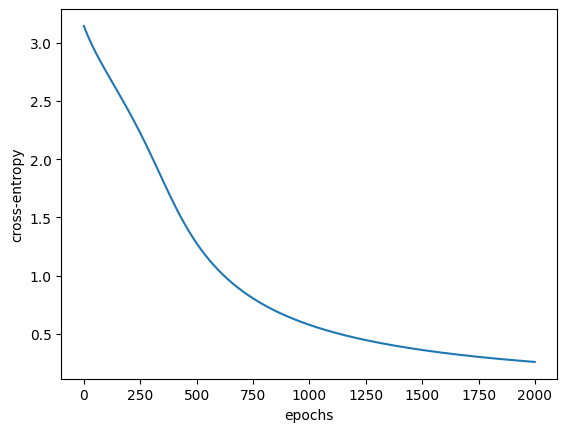

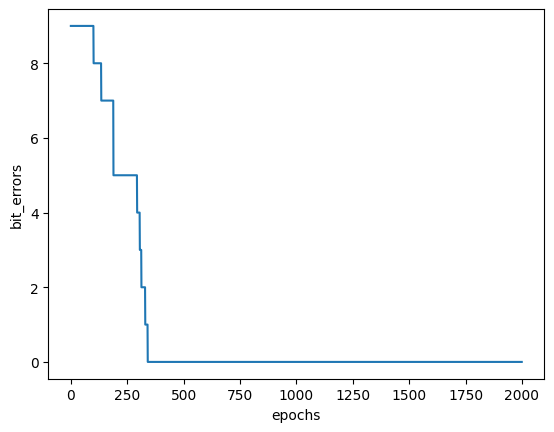

In [ ]:
# Plot the results
pylab.figure()
pylab.plot(range(epochs), l)
pylab.xlabel('epochs')
pylab.ylabel('cross-entropy')
pylab.savefig('./figures/10.1_1.png')

pylab.figure()
pylab.plot(range(epochs), bl)
pylab.xlabel('epochs')
pylab.ylabel('bit_errors')
pylab.savefig('./figures/10.1_2.png')

pylab.show()